<a href="https://colab.research.google.com/github/mkirby1995/Tanzania_water_project/blob/master/Tanzania_Blog_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I usually find it helpful to examine a dataset's individual qualities before diving head first into cleaning, wrangleing, and feature engineering. Not every dataset is the same and different data will require a different plan of attack. Pandas provides us `.info()` which prints a DataFrame's shape (59,400 instances, and 43 features), feature names, feature types, a count of non-null values for each feature, and the DataFrame's memory usage (19.9MB), it's a real workhorse. 

In [1]:
import pandas as pd

features = 'https://raw.githubusercontent.com/mkirby1995/Tanzania_water_project/master/train_features.csv'
target = 'https://raw.githubusercontent.com/mkirby1995/Tanzania_water_project/master/train_labels.csv'

features = pd.read_csv(features)
labels = pd.read_csv(target)

df = features.merge(labels, on = features.index)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 43 columns):
key_0                    59400 non-null int64
id_x                     59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
pu



---



**Labels**

There are three possible values:

* functional : the waterpoint is operational and there are no repairs needed

* functional needs repair : the waterpoint is operational, but needs repairs

* non functional : the waterpoint is not operational

**Features**

Your goal is to predict the operating condition of a waterpoint for each record in the dataset.

* amount_tsh : Total static head (amount water available to waterpoint)

* date_recorded : The date the row was entered

* funder : Who funded the well

* gps_height : Altitude of the well

* installer : Organization that installed the well

* longitude : GPS coordinate

* latitude : GPS coordinate

* wpt_name : Name of the waterpoint if there is one

* num_private :

* basin : Geographic water basin

* subvillage : Geographic location

* region : Geographic location

* region_code : Geographic location (coded)

* district_code : Geographic location (coded)

* lga : Geographic location

* ward : Geographic location

* population : Population around the well

* public_meeting : True/False

* recorded_by : Group entering this row of data

* scheme_management : Who operates the waterpoint

* scheme_name : Who operates the waterpoint

* permit : If the waterpoint is permitted

* construction_year : Year the waterpoint was constructed

* extraction_type : The kind of extraction the waterpoint uses

* extraction_type_group : The kind of extraction the waterpoint uses

* extraction_type_class : The kind of extraction the waterpoint uses

* management : How the waterpoint is managed

* management_group : How the waterpoint is managed

* payment : What the water costs

* payment_type : What the water costs

* water_quality : The quality of the water

* quality_group : The quality of the water

* quantity : The quantity of water

* quantity_group : The quantity of water

* source : The source of the water

* source_type : The source of the water

* source_class : The source of the water

* waterpoint_type : The kind of waterpoint

* waterpoint_type_group : The kind of waterpoint




---



**Clean Null Values**

Finding a good place to start when attacking a dataset for the first time is not a trivial act, as there are usually multiple obvious places to begin cleaning, feature engineering, and exploreatory analysis. I'll offer some reassuring words for the reader here. Just pick a place to start, trust your intuition and just start coding, youll be fine and if you hit a brick wall don't be afraid to retreat, regroup, and attack elsewhere. We will start with cleaning some null values.

In [0]:
def null_value_counts(DataFrame):
  feature_list = []
  
  null_values = []
  
  for _ in range(len(DataFrame.isnull().sum())):
    if DataFrame.isnull().sum()[_] > 0:
      feature_list.append(DataFrame.isnull().sum().index[_])
      null_values.append(DataFrame.isnull().sum()[_])
      
      
  null_dict = dict(zip(feature_list, null_values))
  
  return null_dict

In [3]:
null_columns = null_value_counts(df)
null_columns

{'funder': 3635,
 'installer': 3655,
 'permit': 3056,
 'public_meeting': 3334,
 'scheme_management': 3877,
 'scheme_name': 28166,
 'subvillage': 371}

We will fill these null values with 0. This could be reguarded by many as a bad move, but we will andvance foreward with the assurance that we can always come back and change our strategy if we discover it causes a problem.

In [0]:
for column in null_columns.keys():
  df[column] = df[column].fillna(0)



---



Next lets do some exploratory visualization

A litle feature engineering

In [0]:
df['construction_year'] = df['construction_year'].replace({0:1993})
df['age'] = df['date_recorded'].astype(str).str[:4].astype(int) - df['construction_year']

In [6]:
df['age'].describe()

count    59400.000000
mean        16.436919
std         10.198729
min         -7.000000
25%          8.000000
50%         18.000000
75%         19.000000
max         53.000000
Name: age, dtype: float64

In [0]:
import matplotlib.pyplot as plt
import numpy as np

A Little more engineering scaling encoding etc.

In [0]:
def reverse_cardinality_check(n, df):
  """
  Given a cardinality limit (n) and a dataframe this function will search the
  dataframe for features above the cardinality limit, then create a dict
  from the results
  """
  
  feature_list = []
  
  cardinality_value = []
  
  for _ in range(len(df.columns)):
    if len(df[df.columns[_]].value_counts()) > n:
      
      feature_list.append(df.columns[_])
      
      cardinality_value.append(len(df[df.columns[_]].value_counts()))
                               
        
  feature_dict = dict(zip(feature_list, cardinality_value))
  
  return feature_dict

In [0]:
df = df.drop(columns=['status_group', 'key_0'])

In [0]:
df['pop/year'] = df['population'].replace({0:1}) / df['age'].replace({0:1})

In [0]:
df['water_/_person'] = df['amount_tsh'].replace({0:1}) / df['population'].replace({0:1})

In [12]:
high_cardinality_feature_dict = reverse_cardinality_check(150, df)
high_cardinality_feature_dict

{'date_recorded': 356,
 'funder': 1898,
 'gps_height': 2428,
 'id_x': 59400,
 'id_y': 59400,
 'installer': 2146,
 'latitude': 57517,
 'longitude': 57516,
 'pop/year': 4421,
 'population': 1049,
 'scheme_name': 2697,
 'subvillage': 19288,
 'ward': 2092,
 'water_/_person': 2633,
 'wpt_name': 37400}

In [13]:
low_cardinality_features = df.drop(columns = list(high_cardinality_feature_dict.keys()))
low_cardinality_features.columns

Index(['amount_tsh', 'num_private', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'public_meeting', 'recorded_by',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'age'],
      dtype='object')

In [14]:
high_cardinality_features = df[list(high_cardinality_feature_dict.keys())]
high_cardinality_features.columns

Index(['id_x', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'subvillage', 'ward', 'population',
       'scheme_name', 'id_y', 'pop/year', 'water_/_person'],
      dtype='object')

In [15]:
!pip install category_encoders

     |████████████████████████████████| 92kB 5.7MB/s 


In [0]:
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

In [0]:
one_hot_encode = ce.OneHotEncoder(use_cat_names=True)
one_hot_encode.fit(low_cardinality_features, labels['status_group'])
low_cardinality_features = one_hot_encode.transform(low_cardinality_features)

ordinal_encode = ce.OrdinalEncoder()
ordinal_encode.fit(high_cardinality_features, labels['status_group'])
high_cardinality_features = ordinal_encode.transform(high_cardinality_features)

In [0]:
features = low_cardinality_features.merge(high_cardinality_features,
                                          on = low_cardinality_features.index)

In [19]:
feature_names = features.columns
feature_names

Index(['key_0', 'amount_tsh', 'num_private', 'basin_Lake Nyasa',
       'basin_Lake Victoria', 'basin_Pangani', 'basin_Ruvuma / Southern Coast',
       'basin_Internal', 'basin_Lake Tanganyika', 'basin_Wami / Ruvu',
       ...
       'longitude', 'latitude', 'wpt_name', 'subvillage', 'ward', 'population',
       'scheme_name', 'id_y', 'pop/year', 'water_/_person'],
      dtype='object', length=321)

In [0]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(features, labels['status_group'])
features = imputer.transform(features)

In [0]:
scaler = RobustScaler()
scaler.fit(features, labels['status_group'])
features = scaler.transform(features)

Lets baseline 

In [0]:
X_matrix, y_vector = features, labels['status_group']

In [26]:
majority_class = y_vector.mode()

y_vector.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [27]:
from sklearn.metrics import accuracy_score

majority_prediction = [majority_class] * len(y_vector)

accuracy_score(y_vector, majority_prediction)

0.543080808080808

Lets overfit

In [37]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(max_depth=50)

# Fit the model
decision_tree.fit(X_matrix, y_vector)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [38]:
import graphviz
from sklearn.tree import export_graphviz

# Visualize the tree
dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names,
                           class_names=['Functional', 'Needs Repair', 'Not-Functional'],
                           filled=True, impurity=False, proportion=True)

graphviz.Source(dot_data)

KeyboardInterrupt: ignored

In [39]:
decision_tree_predictions = decision_tree.predict(X_matrix)

accuracy_score(y_vector, decision_tree_predictions)

0.9994781144781145

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

def con_matrix_analysis(model):
  x = model.predict(X_matrix)
  
  print(classification_report(y_vector, x,
        target_names=['Functional', 'Needs Repair', 'Not-Functional']))

  con_matrix = pd.DataFrame(confusion_matrix(y_vector, x), 
             columns=['Predicted Functional', 'Predicted Needs Repair', 'Predicted Not-Functional'], 
             index=['Actual Functional', 'Actual Needs Repair', 'Actual Not-Functional'])
                            
  sns.heatmap(data=con_matrix, cmap='cool')
  plt.show();
  return con_matrix

                precision    recall  f1-score   support

    Functional       1.00      1.00      1.00     32259
  Needs Repair       1.00      1.00      1.00      4317
Not-Functional       1.00      1.00      1.00     22824

      accuracy                           1.00     59400
     macro avg       1.00      1.00      1.00     59400
  weighted avg       1.00      1.00      1.00     59400



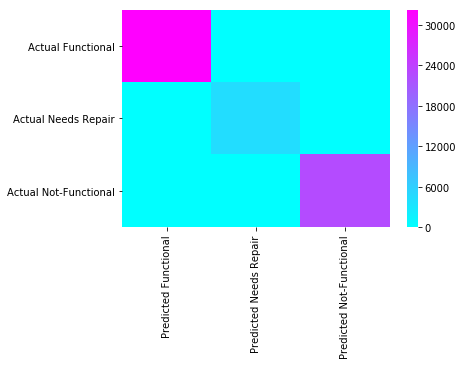

,Predicted Functional,Predicted Needs Repair,Predicted Not-Functional
Actual Functional,32259,0,0
Actual Needs Repair,15,4302,0
Actual Not-Functional,15,1,22808


In [41]:
import seaborn as sns

con_matrix_analysis(decision_tree)

Lets create an accurate model

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

param_distributions = {
    'max_depth': [25, 26, 27, 28]
    #'n_estimators': [90, 91, 92, 93, 94]
}

gridsearch = RandomizedSearchCV(
    RandomForestClassifier(n_estimators=92, n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

gridsearch.fit(X_matrix, y_vector)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=92, n_jobs=-1,
                                                    oob_

In [46]:
results = pd.DataFrame(gridsearch.cv_results_)
print(f'Best result from search of {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head(5)

Best result from search of 4 parameter combinations


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,28.566819,0.283922,0.789299,0.056341,27,{'max_depth': 27},0.813652,0.808939,0.812879,0.810354,0.809901,0.811145,0.001807,1,0.986721,0.987142,0.986869,0.986511,0.987900,0.987029,0.000482
1,29.373631,0.867791,0.811735,0.090054,26,{'max_depth': 26},0.811295,0.807087,0.815067,0.810185,0.806533,0.810034,0.003095,2,0.980387,0.984259,0.980324,0.982428,0.984028,0.982285,0.001697
3,28.735539,0.261673,0.712012,0.199345,28,{'max_depth': 28},0.812137,0.808265,0.810101,0.809680,0.809143,0.809865,0.001291,3,0.990383,0.991982,0.990004,0.991162,0.991709,0.991048,0.000756
0,29.936562,0.559509,0.734516,0.094591,25,{'max_depth': 25},0.814241,0.807087,0.810269,0.809007,0.808301,0.809781,0.002457,4,0.972874,0.975231,0.972875,0.975737,0.976916,0.974726,0.001608


In [0]:
model = gridsearch.best_estimator_

                precision    recall  f1-score   support

    Functional       0.97      1.00      0.99     32259
  Needs Repair       1.00      0.92      0.96      4317
Not-Functional       1.00      0.97      0.99     22824

      accuracy                           0.98     59400
     macro avg       0.99      0.96      0.98     59400
  weighted avg       0.98      0.98      0.98     59400



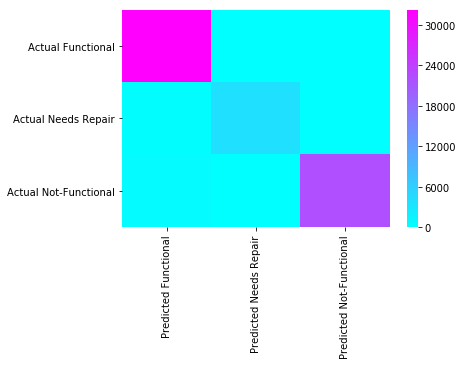

,Predicted Functional,Predicted Needs Repair,Predicted Not-Functional
Actual Functional,32238,0,21
Actual Needs Repair,348,3953,16
Actual Not-Functional,600,0,22224


In [48]:
con_matrix_analysis(model)